In [0]:
import requests
import json
from collections import Counter
import random

#import matplotlib.pyplot as plt
#import seaborn as sns

#from sklearn import preprocessing
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#from sklearn.decomposition import PCA
#from sklearn.pipeline import Pipeline

import pandas as pd # data preprocessing
import numpy as np # linear algebra

#import tensorflow as tf
#from tensorflow.keras import layers
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

# Part 1: Train a first Neural Network
El objetivo del siguiente notebook es entrenar una red neuronal simple para predecir dominios del dataset.

A continuación se muestra la arquitectura de la red a entrenar.


![Google's logo](https://www.google.com/images/logos/google_logo_41.png)

## Download the dataset
El siguiente código descarga el dataset ubicado en Google Drive y lo descomprime 

In [2]:
#dataset_url = 'https://drive.google.com/file/d/1XbasZMZzSmMUbji1Sslg4vT5MBiIhyFO/view?usp=sharing'

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


#download_file_from_google_drive('1BXQGSYbpdDaQdR_MeYfw1q4OjfmyXdmh', 'dataset.zip')                
#!unzip 'dataset.zip'

download_file_from_google_drive('1nzvm--XkmhjHgngNdjaemFIViXekaVWx', 'sm_dataset.zip')
!unzip 'sm_dataset.zip'

Archive:  sm_dataset.zip
  inflating: dataset.csv             
   creating: __MACOSX/
  inflating: __MACOSX/._dataset.csv  


## Load the dataset using pandas
The dataset is a csv file separated with tabs

In [0]:
df = pd.read_csv('dataset.csv', sep='\t')

## Explore the data

Let's do some checks to see if the data makes sense

In [4]:
df.head()

,domain_id,title
0,SANDALS_AND_FLIP_FLOPS,Sandalias Con Plataforma Mini Viamo Usadas Num 33/34 Niña
1,SPARK_PLUG_WIRESETS,Cable Para Bujia Prestolite (1127) Peugeot 405/1.8/1.9/2.0 1
2,MOTORCYCLE_HANDLEBAR_GRIPS,Protectores Mda Monster Zanella Zb D 110 4t 2005....
3,MOTORCYCLE_TIRES,Cubierta Moto 250 17 Hd01-1 Okinoi Okinoi - 110
4,AUTOMOTIVE_FILTER_KITS,Kit De Filtros Wega Toyota Hilux 2011


First, find how many classes we have in the dataset. This classes will be the output of the Neural Network

In [5]:
print("Número de classes:", len(df.domain_id.unique()))

Número de classes: 100


¿How many items do we have in the dataset?

In [6]:
print("Número de ejemplos:", len(df))

Número de ejemplos: 464092


Count how many items we have per class and:
 1. Make a line plot
 2. Plot a histogram distribution to see how balanced are the classes

(0, 5500)

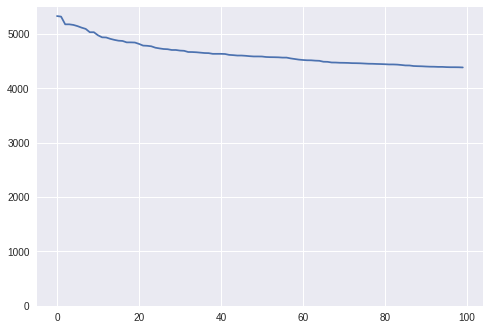

In [7]:
plt = (df.groupby('domain_id')
             .count()
             .sort_values('title', ascending=False)
             .reset_index()[['domain_id','title']]
             .rename(columns={"title":"counts"}))['counts'].plot.line()
plt.set_ylim(0,5500)

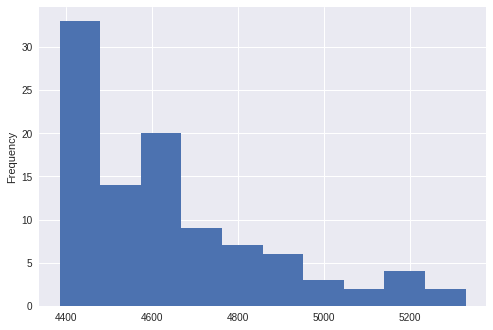

In [8]:
(df.groupby('domain_id')
             .count()
             .reset_index()[['domain_id','title']]
             .rename(columns={"title":"counts"}))['counts'].plot.hist()

## Prepare the data

In [0]:
max_items = 10000

### Tokenization

Create a vocabulary of words.

That is, given the text of the dataset, return a dict of word -> index 

["Kit De Filtros Wega Toyota Hilux 2011", "Protectores Mda Monster", ...]

{"kit":0, "de":1, ... ,"monster":121, ...}

View https://keras.io/preprocessing/text/

In [0]:
def build_tokenizer(corpus, num_features=20000):
  tokenizer = text.Tokenizer(num_words=num_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
  tokenizer.fit_on_texts(corpus)
  return tokenizer
  

In [77]:
import time
tic = time.time()

tokenizer = build_tokenizer(df['title'].values)

toc = time.time()    
print("Time to create tokenizer: " + str(1000*(toc-tic)) + " ms")


Time to create tokenizer: 9914.585590362549 ms


**word_counts**: ordereddict("word": "count")

**word_docs**: dic("word": "count docs it appears")

**word_index**: Vocabulary dict("word":index)

**document_count**:int #doc used to fit the Tokenizer.

In [0]:
#print(tokenizer.word_counts)
#print(tokenizer.word_counts)
#print(tokenizer.word_index)
#print(tokenizer.document_count)
#print(tokenizer.word_docs)

### Vectorization
Now, it is time to vectorizer each individual example using the tokenizer we just created

**binary**: Default, 1/0

**count**: BoW

**tfidf**: Term Frequency-Inverse Document Frequency

**freq**: Term Frequency as ratio within the document


In [0]:
'''This function returns a sequence of indices representing the text'''
def vectorize_text(text, tokenizer, max_seq_length=12):  
  # Vectorize training and validation texts.
  text_sequences = tokenizer.texts_to_sequences(text)

  # Get max sequence length.
  max_length = len(max(text_sequences, key=len))
  if max_length > max_seq_length:
      max_length = max_seq_length

  # Fix sequence length to max value. Sequences shorter than the length are
  # padded in the beginning and sequences longer are truncated
  # at the beginning.
  text_sequences = sequence.pad_sequences(text_sequences, maxlen=max_length)
  
  return text_sequences

In [86]:
x_vectors = vectorize_text(df['title'].values[:100], tokenizer)
print(x_vectors.shape)
x_vectors_encoded = tokenizer.sequences_to_matrix(x_vectors.tolist(), mode="count")
print(x_vectors_encoded.shape)

(100, 12)
(100, 20000)


Explore generated features

In [87]:
example_idx = 1000
print(df['title'].values[example_idx])
#print(text_sequences[1].tolist())
idx_tkn ={idx:tkn for tkn, idx in tokenizer.word_index.items()}
for tkn in text_sequences[example_idx].tolist():
  if tkn > 0:
    print(idx_tkn[tkn] ,encoded_docs[example_idx][tkn])


Maceta  Rotomoldeada  Con  Plantas De Interior Y Exterior
maceta 0.0
con 1.0
plantas 0.0
de 1.0
interior 0.0
y 1.0
exterior 0.0


### Vectorize the labels

Add a new column to the pandas dataframe with a integer representing the class label


In [0]:
from tensorflow.python.keras.utils import to_categorical

'''This function append a new column called "label" with an integer that uniquely identify that domain_id.
See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html
'''
def vectorize_labels(df):
  df['label'] = df['domain_id'].factorize()[0]

'''We will be using categorical_crossentropy loss function (softmax), for this reason, we need to use one_hot encoding for our labels
  This menas, the representation should look like: [0, 0, ..., 1, 0] sparse vector with a "1" in the position of the target label.
  See https://keras.io/utils/ (to_categorial function)
'''  

def encode_labels(labels):
  # Convert labels to categorical one-hot encoding
  one_hot_labels = to_categorical(labels)
  return one_hot_labels
  
  
'''This builds the labels vocabulary. It shoud return a dictionary with the following format: 
{..., 1: "TABLETS", 2: "CELLPHONES", ...}
'''
def build_idx_to_label(df):
  idx_to_label = {idx:domain_id for domain_id, idx in df.groupby(['domain_id', 'label']).groups.keys()}
  return idx_to_label


Check that all the training examples belonging to the same domain have the same vectorizer label

In [150]:
vectorize_labels(df)  
idx_to_label = build_idx_to_label(df)

assert df[df['label']==3].reset_index().iloc[0]['domain_id'] == idx_to_label[3]
df.head()

labels = encode_labels(df['label'].values)
print(df.iloc[0]['domain_id'], df.iloc[0]['label'])
assert labels[0][df.iloc[0]['label']] == 1 

SANDALS_AND_FLIP_FLOPS 0


### Split the dataset in Train, Dev and Test sets

NOTE: Remember to always random shuffle the dataset before splitting it.

See:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html


In [0]:
def split_dataset(df, train_size=10000, dev_size=1000, test_size=1000):
  # Random shuffle the dataset rows
  df = df.sample(frac=1).reset_index(drop=True)
  df_train = df[:train_size].reset_index(drop=True)
  df_dev = df[train_size:(train_size+dev_size)].reset_index(drop=True)
  df_test = df[(train_size + dev_size):(train_size + dev_size + test_size)].reset_index(drop=True)
  return df_train, df_dev, df_test

In [0]:
df_train, df_dev, df_test = split_dataset(df)
assert len(df_train) == 10000
assert len(df_dev) == 1000
assert len(df_test) == 1000

Finally, create the encoder for the different sets

In [0]:
x_train = vectorize_text(df_train['title'].values, tokenizer)
x_train_encoded = tokenizer.sequences_to_matrix(x_train.tolist(), mode="count")
y_train_encoded = encode_labels(df_train['label'].values)

x_dev = vectorize_text(df_dev['title'].values, tokenizer)
x_dev_encoded = tokenizer.sequences_to_matrix(x_dev.tolist(), mode="count")
y_dev_encoded = encode_labels(df_dev['label'].values)

x_test = vectorize_text(df_test['title'].values, tokenizer)
x_test_encoded = tokenizer.sequences_to_matrix(x_test.tolist(), mode="count")
y_test_encoded = encode_labels(df_test['label'].values)

In [154]:
print(x_train_encoded.shape)
print(y_train_encoded.shape)

(10000, 20000)
(10000, 100)


## Build the model

We will first create a model using Keras Sequential API

Learn More: https://keras.io/getting-started/sequential-model-guide/

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation

def build_model(num_features, num_classes):
  model = Sequential([
      Dense(1024, input_shape=(num_features,)),
      Activation('relu'),
      Dense(num_classes),
      Activation('softmax'),
  ])

  # For a multi-class classification problem
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [0]:
model = build_model(x_train_encoded.shape[1], y_train_encoded.shape[1])

### Visualizing the Neural Network

In [107]:
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              20481024  
_________________________________________________________________
activation_4 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               102500    
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
Total params: 20,583,524
Trainable params: 20,583,524
Non-trainable params: 0
_________________________________________________________________
None


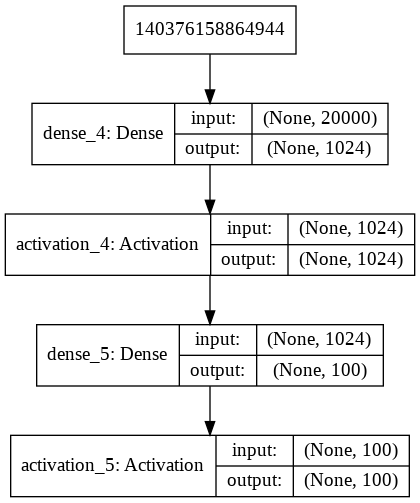

In [108]:
from keras.utils import plot_model
from IPython.display import Image

# Model summary
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

## Train the model

It is time to train the model

See: https://keras.io/models/model/ (fit function)

In [109]:
# Train and validate model.
history = model.fit(
    x_train_encoded,
    y_train_encoded,
    epochs=10,
    validation_data=(x_dev_encoded, y_dev_encoded),
    verbose=1,  # Logs once per epoch.
    batch_size=256)

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 3s 296us/sample - loss: 3.8118 - acc: 0.5569 - val_loss: 2.4668 - val_acc: 0.8280
Epoch 2/10
10000/10000 [==============================] - 3s 261us/sample - loss: 1.2663 - acc: 0.9137 - val_loss: 0.8718 - val_acc: 0.8950
Epoch 3/10
10000/10000 [==============================] - 3s 262us/sample - loss: 0.3603 - acc: 0.9649 - val_loss: 0.5803 - val_acc: 0.9080
Epoch 4/10
10000/10000 [==============================] - 3s 263us/sample - loss: 0.1705 - acc: 0.9819 - val_loss: 0.5003 - val_acc: 0.9130
Epoch 5/10
10000/10000 [==============================] - 3s 259us/sample - loss: 0.0976 - acc: 0.9919 - val_loss: 0.4640 - val_acc: 0.9120
Epoch 6/10
10000/10000 [==============================] - 3s 261us/sample - loss: 0.0651 - acc: 0.9952 - val_loss: 0.4316 - val_acc: 0.9130
Epoch 7/10
10000/10000 [==============================] - 3s 259us/sample - loss: 0.0474 - acc: 0.9955 - val_lo

### Visualizing learning curve

In [0]:
import matplotlib.pyplot as plt

def visualize_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

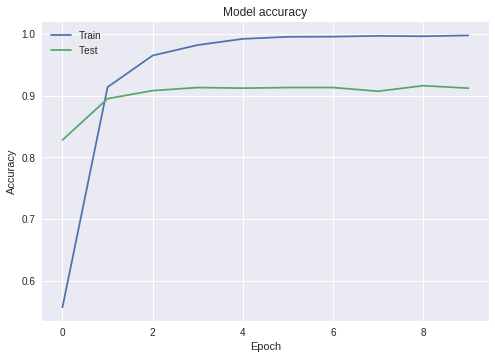

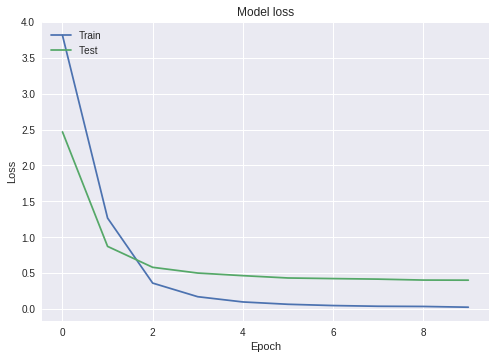

In [111]:
visualize_training_history(history)

## Evaluate the model on the test set

In [0]:
y_pred_test = model.predict(x_test_encoded)

In [117]:
y_pred_test.shape


(1000,)

### Visualize the Confusion Matrix

In [115]:
# https://github.com/sepandhaghighi/pycm
!pip install pycm==1.8

    100% |████████████████████████████████| 215kB 28.1MB/s 
datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.2 which is incompatible.
coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.2 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


In [0]:
from pycm import *

y_pred = np.argmax(y_pred_test, axis=1)
y_act = np.argmax(y_test_encoded, axis=1)

cm = ConfusionMatrix(actual_vector=y_act, predict_vector=y_pred)

In [129]:
#cm.print_matrix()
#cm.print_normalized_matrix()
print(idx_to_label[2], len(df_test[df_test['domain_id']==idx_to_label[2]]))
cm.print_matrix(one_vs_all=True,class_name=2)

MOTORCYCLE_HANDLEBAR_GRIPS 7
Predict          2      ~      
Actual
2                7      0      

~                0      993    




In [0]:
def print_errors(df_s, y_act, y_pred, idx_to_label):
  for idx, row in df_s.iterrows():
    if y_act[idx] != y_pred[idx]:
      print(row['title'], 'Truth:', row['domain_id'], 'Prediction:',idx_to_label[y_pred[idx]])

In [157]:
print(y_act[:10])
print(y_pred[:10])
print(df_test.iloc[0]['title'], df_test.iloc[0]['domain_id'], idx_to_label[y_pred[0]])
print(idx_to_label[y_pred[0]])


[44 48 51 86 30  1 47 46 36 45]
[44 48 51 86 30  1 47 46 36 45]
Kit De Embrague Peugeot 307 Sw 1.6 Hdi 16v 100% Original AUTOMOTIVE_CLUTCH_KITS PLANTS
PLANTS


In [156]:
print_errors(df_test, y_act, y_pred, idx_to_label)

Motor Burro De Arranque Mercedes Benz 615d 1996 1997 1998 Truth: STARTERS Prediction: DATA_CABLES
Inyectores Ford Escort 1.8 95/02 Truth: FUEL_INJECTORS Prediction: MANGA
Lego 41145 Disney Ariel Y El Hechizo Mágico Envio S/c Truth: TOY_BUILDING_SETS Prediction: DECORATIVE_VINYLS
Soporte De Motor Chevrolet S-10 Con Motor Mwm Rey Goma Truth: AUTOMOTIVE_ENGINE_MOUNTS Prediction: DIECAST_CARS
Cuadro Rey De Prusia Friedrich Der Grobe Truth: PAINTINGS Prediction: COLLECTIBLE_POSTAGE_STAMPS
El Marginal  Serie Completa En Dvd 720p Tv Publica Truth: TV_SERIES Prediction: INTEGRATED_CIRCUITS
Calco Levanta Baul - Envios A Todo El Pais Truth: VEHICLE_STICKERS Prediction: DIECAST_CARS
Insignias De Mercedes 1517 Truth: AUTOMOTIVE_EMBLEMS Prediction: AUTOMOTIVE_MOLDINGS
Lapicera Faber - Castell Basic (18145) Truth: PENS Prediction: PANTS
Filtro Aire Brava Altino180  Original Paredesbiker Truth: MOTORCYCLE_AIR_FILTERS Prediction: WOMEN_SWIMWEAR
Cuadros Decorativos Dachsund - Perro Salchicha Art 27x42c

# Part 2: Recurrent Neural Network

In [0]:
train_length = 30000
x_train = text_sequences[:train_length]
y_train = one_hot_labels[:train_length]

x_val = text_sequences[train_length:]
y_val = one_hot_labels[train_length:]

print(text_sequences.shape)
print(encoded_docs.shape)

(10000, 12)
(10000, 20000)


## RNN same approach

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, LSTM, Embedding, Masking

num_features = encoded_docs.shape[1]
title_max_length = text_sequences.shape[1]

model = Sequential([
    LSTM(units=512, input_shape=title_max_length),
    Dropout(0.5),
    Dense(len(df[:max_items].domain_id.unique()), activation='softmax')
])

# For a multi-class classification problem
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train and validate model.
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=1,  # Logs once per epoch.
    batch_size=256)

## RNN using embedding Layer

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, LSTM, Embedding, Masking

num_features = encoded_docs.shape[1]
title_max_length = text_sequences.shape[1]

rnn_model = Sequential([
    Embedding(input_dim=num_features,
              output_dim=200,
              input_length=title_max_length),
    LSTM(units=512),
    Dropout(0.5),
    Dense(len(df[:max_items].domain_id.unique()), activation='softmax')
])

# For a multi-class classification problem
rnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train and validate model.
history = rnn_model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=1,  # Logs once per epoch.
    batch_size=256)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 3s 413us/sample - loss: 4.5352 - acc: 0.0200 - val_loss: 4.3271 - val_acc: 0.0235
Epoch 2/20
8000/8000 [==============================] - 2s 274us/sample - loss: 4.0951 - acc: 0.0419 - val_loss: 3.8227 - val_acc: 0.0685
Epoch 3/20
8000/8000 [==============================] - 2s 279us/sample - loss: 3.2520 - acc: 0.1670 - val_loss: 2.7044 - val_acc: 0.2905
Epoch 4/20
8000/8000 [==============================] - 2s 279us/sample - loss: 1.7753 - acc: 0.5155 - val_loss: 1.5731 - val_acc: 0.6230
Epoch 5/20
8000/8000 [==============================] - 2s 277us/sample - loss: 0.7736 - acc: 0.7939 - val_loss: 1.0830 - val_acc: 0.7660
Epoch 6/20
8000/8000 [==============================] - 2s 278us/sample - loss: 0.3694 - acc: 0.9061 - val_loss: 0.9212 - val_acc: 0.8100
Epoch 7/20
8000/8000 [==============================] - 2s 279us/sample - loss: 0.1947 - acc: 0.9561 - val_loss: 0.8919 - va

## Visualize Word Embeddings

In [0]:
!pip install ggplot

from sklearn.manifold import TSNE
from ggplot import *


embedding_model = Sequential([
    Embedding(input_dim=num_features,
              output_dim=200,
              input_length=title_max_length,
              weights=rnn_model.layers[0].get_weights())
])

def get_embeddings(titles, flatten=False):
    seq = tokenizer.texts_to_sequences(titles)
    max_sentence_length = 12
    padded = sequence.pad_sequences(seq, max_sentence_length)
    prediction = embedding_model.predict(padded)
    
    if flatten:
        return [np.ndarray.flatten(e) for e in prediction]
    
    return prediction

In [0]:
def visualize_embeddings(x_titles):

  np.random.shuffle(x_titles)

  perplexity = 14

  emb_titles = np.array(get_embeddings(x_titles, flatten=True))

  X_embedded = TSNE(n_components=2 , perplexity=perplexity, init='pca', random_state=8).fit_transform(emb_titles)

  fig, ax = plt.subplots(figsize=(14,14), dpi=100)
  vis_x = X_embedded[:, 0]
  vis_y = X_embedded[:, 1]
  sc = ax.scatter(vis_x, vis_y, c = np.array(range(len(vis_y))), cmap=plt.cm.get_cmap("jet", 10))
  fig.show()

  max_label_length = 30

  for i in range(len(vis_y)):
      annot = ax.annotate(x_titles[i][: max_label_length], (vis_x[i], vis_y[i]))

In [0]:
#list(tokenizer.word_counts)[:100]

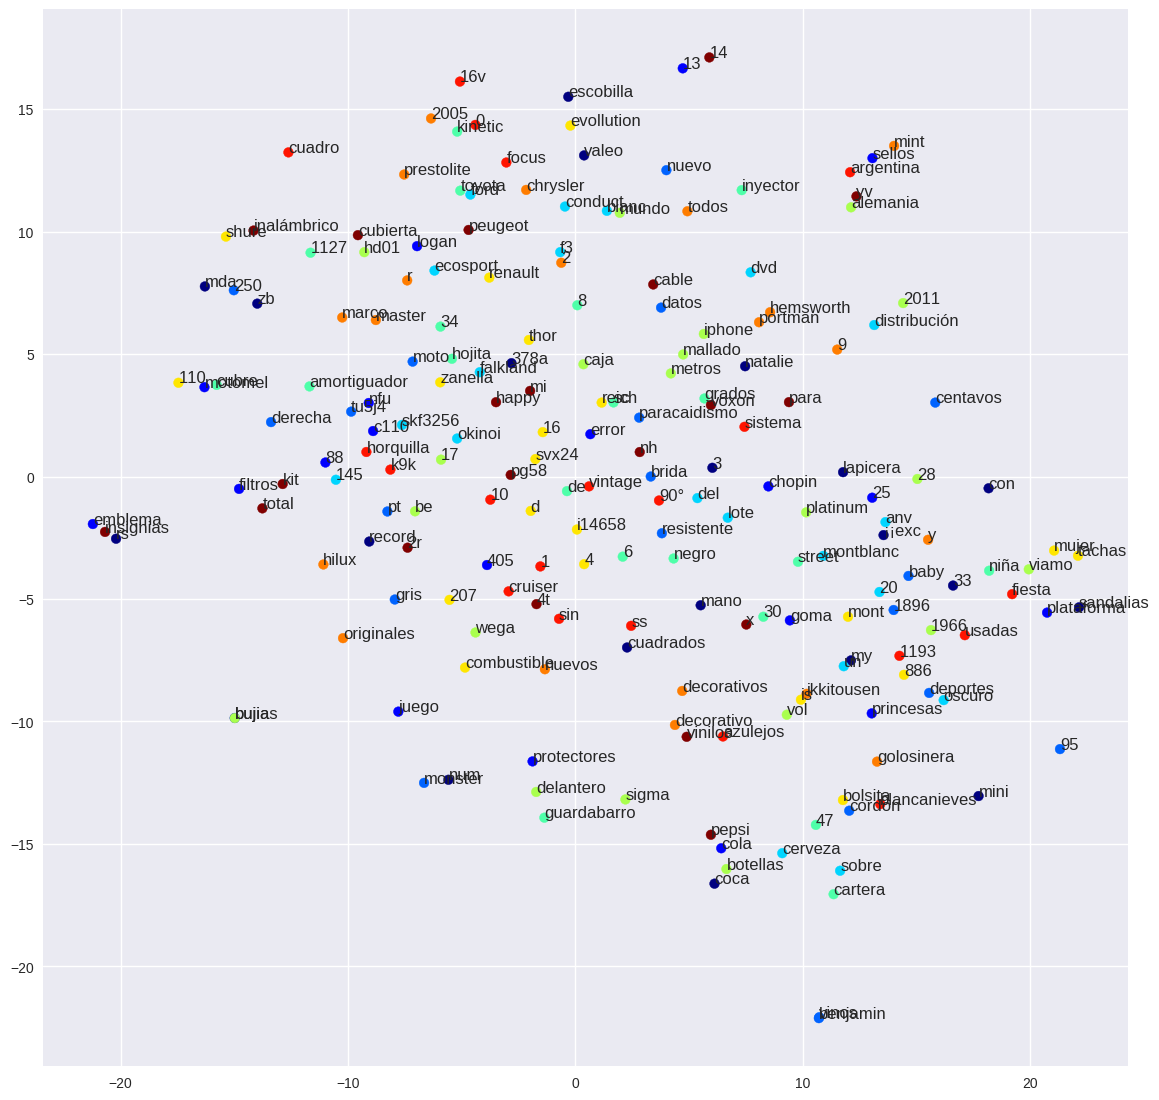

In [0]:
  x_titles = list(tokenizer.word_counts)[:200]
  
  visualize_embeddings(x_titles)

In [0]:
df.head(100)

,domain_id,title,label
0,SANDALS_AND_FLIP_FLOPS,Sandalias Con Plataforma Mini Viamo Usadas Num 33/34 Niña,0
1,SPARK_PLUG_WIRESETS,Cable Para Bujia Prestolite (1127) Peugeot 405/1.8/1.9/2.0 1,1
2,MOTORCYCLE_HANDLEBAR_GRIPS,Protectores Mda Monster Zanella Zb D 110 4t 2005....,2
3,MOTORCYCLE_TIRES,Cubierta Moto 250 17 Hd01-1 Okinoi Okinoi - 110,3
4,AUTOMOTIVE_FILTER_KITS,Kit De Filtros Wega Toyota Hilux 2011,4
5,FUEL_INJECTORS,Brida Inyector Combustible K9k -todos-1 - I14658,5
6,AUTOMOTIVE_SHOCK_ABSORBERS,Amortiguador Delantero Chrysler Pt Cruiser Record,6
7,MOVIES,Thor Un Mundo Oscuro Dvd Nuevo Natalie Portman Hemsworth,7
8,COMMERCIAL_AND_EVENT_BAGS,Bolsita Golosinera Con Cordon Blancanieves Princesas,8
9,SPARK_PLUGS,Juego 4 Bujias Originales Ecosport Kinetic Focus 3 1.6 Sigma,9
